In [1]:
# MCMC introduction
# Based on some PyMC3 docu examples 
# Jan Nagler, May, 2021, A.C.

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
# set output floats to 5 significant digits throughout the journey
%precision 4 
%matplotlib inline
# This is a massive lib for MCMC 
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))
# pip install git+https://github.com/pymc-devs/pymc3
# just run this commend in your shell
np.random.seed(42)
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Running on PyMC3 v3.11.2


In [2]:
############################## 用一个非常simple的Model: Simple random additive noise as two features
############################## 是由一Distribution产生的
############### 设定model的基本特征 Groundtruth parameter values，即在这一步设定 surrogate data
alpha, sigma = 1, 1 # intercept and std
beta = [1, 2.5] # weights

############### 定义dataset的大小，Size of surrogate dataset
size = 25 # keep this LOW when getting started, increase when you and your CPU are ready

############### 随机产生两个Vr，在2D，Predictor variable，是两个uncorrelated randome uniformly Dist Vr，则可以用Gaussian做prior的noise Dist，因为当你把random # 的noise加起来之后基本上就是Gaussian
X1 = np.random.randn(size) * 2
X2 = np.random.randn(size) * 0.3

############### 产生 Surrogate data set，alpha是这个model的intercept，sigma是model的standard deviation factor乘到normalized之后的随机数组上来获得specified model standard deviation，两个beta是Vr对应的slopes或parameters用来scale上面随机产生的的两个Vr
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma 

############### 下面的图可以看出，X1与Y是高度correlated，X2则不

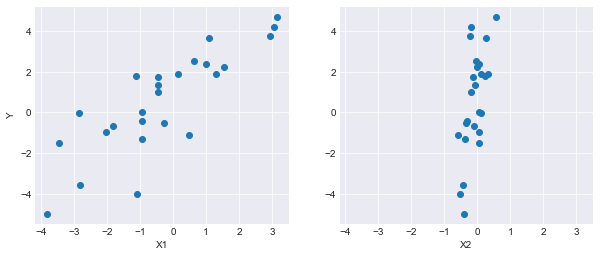

In [3]:
#plot data, projections
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

Define prior distributions for the parameters for which we will be trying to infer posterior distributions

In [5]:
############################## 要建立MCMC首先得有个prior model
############################## Prior的定义没有特定的rule但是你至少得给出点什么
# Build a model 
basic_model = pm.Model()############### 是从pm lib里面call出来的的MCMC basic model

with basic_model: ############### with语句就是个contriner，将你想用的elements放到一起

############### Priors for unknown model parameters 这是定义prior的较为standard的choices，可根据Vr X1 X1的parameters的特征来调整prior的定义，基本上就是一个art，得自己摸索
    alpha = pm.Normal('alpha', mu=0, sigma=10)############### 对这个一无所知，就暂且用个Normal Dist，并加上一个较高的initial guess of sigma=10，不知mean是多少则选mean=mu=0
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)############### 对这个一无所知，就暂且用个Normal Dist，并加上一个较高的initial guess of sigma=10，不知mean是多少则选mean=mu=0
    sigma = pm.HalfNormal('sigma', sigma=1) ############### 因standard deviation >0，则这里用Normal Dist的一半，否则std就会有负数，加上一个initial guess of sigma=1

    ############### Expected value of outcome
    ############### Determinitic random variable, means sharply defined by delta function over data and model param，用data即Vr X1 X2以及他们的parameters加上intercept alpha来定义mu，就是描述整个model Y的中心趋势
    mu = alpha + beta[0]*X1 + beta[1]*X2 

    ############### Likelihood (sampling distribution) of observations, given out surrogate data Y
    ############### Called observed stochastic variable 在这里一步control how potential data deviates from our model, 则用下面Y_obs这个likelihood，用来disturb我们的model，即用下面Y_obs给model介绍进来noise of your priors，用上一个cell定义的Y当做observed值，这个Y_obs比prior更重要，因为你有更少的信息关于这些noise是如何distributed的，则这里就先用Normal Dist,即你本来的model是个Gaussian，这里定义的deviation away from the model也是Gaussian分布的；这个Y_obs的set-up随着Vr本身的特征而改变
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

    ############### 这个with语句里面的所有的东西都会被放入下一个cell的pm.find_MAP()当中，因为pm.find_MAP()需要一些关于prior的信息，及在这个cell的with语句里面定义的alpha，beta，sigma三个prior distributions就算是initiated了，然后用Y_obs这个来call那三个priors Dist，这样才能被plug in到pm.find_MAP()当中，尤其是在下面的pm.NUTS()和trace = pm.sample当中

Perform MCMC: Sample from our prior distribution, simulate the model, and evaluate the likelihood of the data given those input parameters, based on our "basic model", and the "noise" distribution, our (surrogate) data Y. Use Bayesian inference to decide whether to keep the trial points or throw them away. Choose a new set of points and start over.

In [8]:
############################## 这一步正式建立 MCMC Sampling method 
with basic_model:
    
    ############### 首先从prior开始 Compute MAP estimate
    start = pm.find_MAP() ############### args, e.g., model=basic_model, Powell method (no derivatives needed)
    print("Start", start)
    
    ############### 这一步set up sampler， instantiate sampler steps: Optional；可以用下面不同的sampling方法
    #step = pm.Slice()
    #step = pm.Metropolis()
    step = pm.NUTS() ############### NUTS sampler是最先进的方法
    
    ############### 这一步明确# ofchain elements， draw 500 posterior samples，并且在括号里面call sample方法step
    trace = pm.sample(500, step=step)


Start {'alpha': array(1.1157), 'beta': array([1.1423, 2.4072]), 'sigma_log__': array(-0.2311), 'sigma': array(0.7937)}
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 11 seconds.


<ipython-input-9-c41b5f8d2cd3>:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
<ipython-input-9-c41b5f8d2cd3>:4: DeprecationWarning: The function `pairplot` from PyMC3 is just an alias for `plot_pair` from ArviZ. Please switch to `pymc3.plot_pair` or `arviz.plot_pair`.
  pm.pairplot(trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.11,0.18,0.79,1.46,0.00,0.00,2150.0,1580.0,1.00
beta[0],1.14,0.10,0.95,1.31,0.00,0.00,1800.0,1546.0,1.00
beta[1],2.40,0.51,1.50,3.40,0.01,0.01,2218.0,1453.0,1.00
sigma,0.88,0.14,0.65,1.14,0.00,0.00,1630.0,894.0,1.01


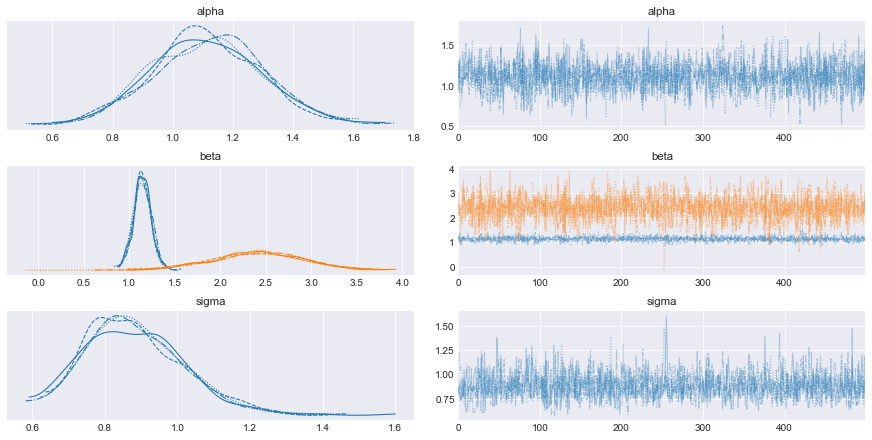

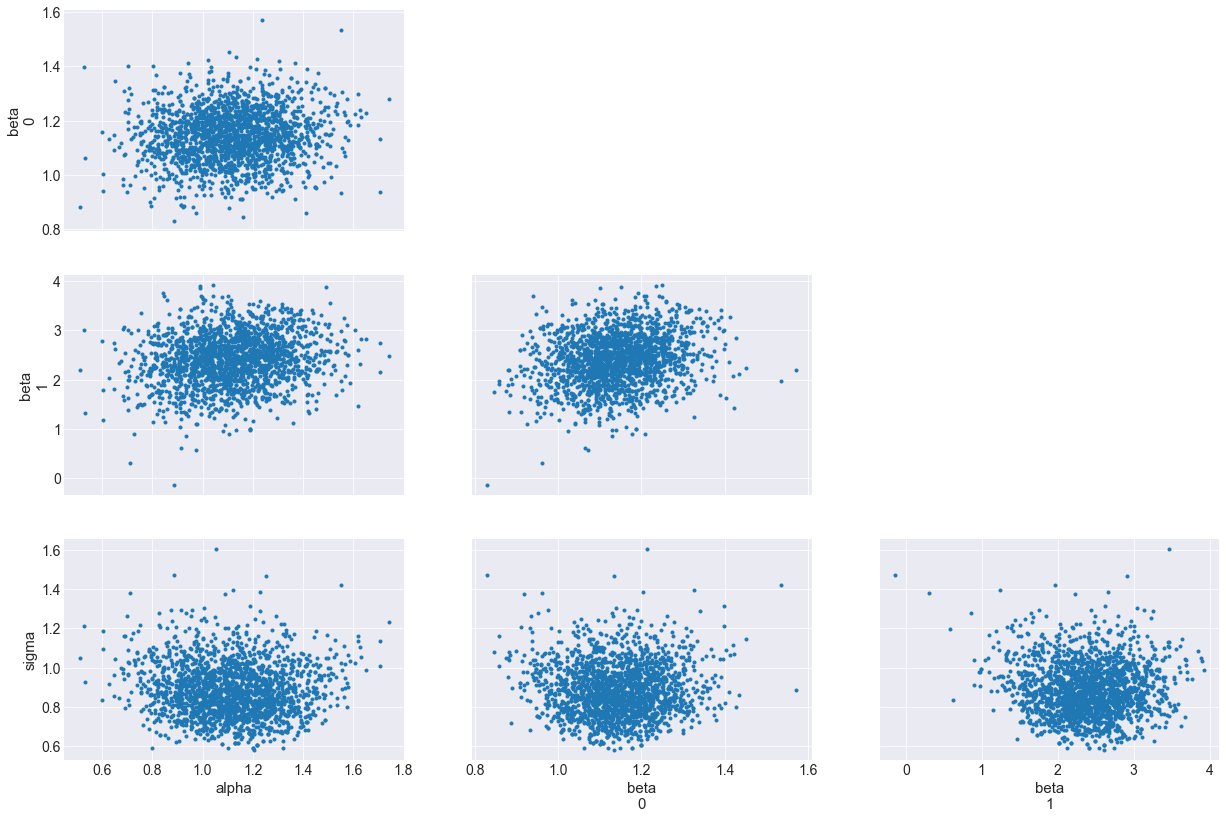

In [9]:
############### 用来看statistical property以及output plot，来检查看output的posterior Dist有多好
pm.traceplot(trace) ############### 就是Markov Chain的元素：左边的图是每个probability density equation of the postriors Dist for each parameter； 右边是 每一个state都显示出来了
#pm.autocorrplot(trace)
pm.pairplot(trace) ############### 用来显示各parameters是如何correlated，横纵跨越各小图来对比对应的parameters
#pm.energyplot(trace) # https://arxiv.org/pdf/1604.00695v1.pdf
pm.summary(trace).round(2)